# Notebook 3: Evaluation and Visualization

**Objective:** The goal of this notebook is to evaluate the performance of our trained PPO agent both qualitatively (by watching it play) and quantitatively (by plotting its learning curve).

We will perform three main tasks:
1.  Load the trained model from the `/models` directory.
2.  Generate GIFs to visually compare the performance of the trained agent vs. an untrained agent.
3.  Parse the TensorBoard log files to plot a graph of the rewards over time, creating a learning curve.

In [2]:
# ==============================================================================
# SETUP AND INSTALLATIONS
# ==============================================================================
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Project Path and Create Symlink
PROJECT_PATH = '/content/drive/My Drive/PortfolioProjects/visual-cart-pole-rl'

# Create a symlink for easy access
if not os.path.exists('/project'):
    !ln -sfn '{PROJECT_PATH}' /project
else:
    print("Symlink '/project' already exists.")

# 3. Install System Dependencies
!apt-get update && apt-get install -y swig

# 4. Install Python Libraries
!pip install gymnasium[box2d] stable-baselines3[extra] opencv-python-headless -q

print("✅ Setup complete. Environment is ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Symlink '/project' already exists.
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [81.0 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,014 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa

## Step 1: Load the Trained Model and Environment

The first step is to load the agent we trained in the previous notebook (250k version). We also need to recreate the exact same wrapped environment that it was trained on so that the model understands the observations it receives.

In [3]:
# ==============================================================================
# CELL 2: LOAD THE MODEL
# ==============================================================================
import sys
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage

# Add the project directory to the system path
if '/project' not in sys.path:
    sys.path.append('/project')

# Import our custom wrapper
from utils.env_preprocessing import ImageWrapper

# --- Parameters ---
MODEL_PATH = "/project/models/ppo_visual_cartpole_250k.zip"

# --- Create the evaluation environment ---
# We only need one environment for evaluation
eval_env = make_vec_env(
    'CartPole-v1',
    n_envs=1,
    env_kwargs={'render_mode': 'rgb_array'},
    wrapper_class=ImageWrapper
)
eval_env = VecTransposeImage(eval_env)

# --- Load the trained model ---
model = PPO.load(MODEL_PATH, env=eval_env)

print("✅ Model and evaluation environment are ready.")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Model and evaluation environment are ready.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Step 2: Generate GIF of the Trained Agent 🎬

Now we will qualitatively evaluate our trained agent. We will run the loaded model in the environment, recording each frame to see how it performs. To get the most consistent results, we will set `deterministic=True` in the prediction step, which makes the agent choose the best-known action every time. We'll also investigate to see the exact reason an episode terminates.

In [41]:
# ==============================================================================
# GENERATE GIF AND VERIFY REWARD, CART POSITION, AND POLE ANGLE (Trained)
# ==============================================================================
import imageio
import numpy as np
import random

# --- Create the environments ---
# 1. Create the base vectorized env first
base_vec_env = make_vec_env('CartPole-v1', n_envs=1, env_kwargs={'render_mode': 'rgb_array'}, wrapper_class=ImageWrapper)

# 2. An unwrapped one to check the true state
unwrapped_env = gym.make('CartPole-v1', render_mode='rgb_array')


# --- Seed the base environment, then wrap it ---
seed = 32
base_vec_env.seed(seed) # Set the seed on the base vectorized env
wrapped_env = VecTransposeImage(base_vec_env) # Now, apply the final wrapper

# Reset the unwrapped env with the same seed
unwrapped_env.reset(seed=seed)
# Reset the wrapped env (it will use the seed we just set)
wrapped_obs = wrapped_env.reset()


# --- Run the episode ---
images = []
total_reward = 0

print("Step | Cart Position | Pole Angle (rad)")
print("------------------------------------------")

for i in range(500):
    action, _ = model.predict(wrapped_obs, deterministic=True)

    wrapped_obs, reward, done, info = wrapped_env.step(action)
    unwrapped_obs, unwrapped_reward, unwrapped_done, _, _ = unwrapped_env.step(action[0])

    cart_pos = unwrapped_obs[0]
    pole_angle = unwrapped_obs[2]

    print(f"{i:4d} | {cart_pos:13.4f} | {pole_angle:16.4f}")

    total_reward += reward[0]
    images.append(unwrapped_env.render())

    if done:
        print("\n--- Episode Terminated ---")
        print(f"Final Cart Position: {cart_pos:.4f} (Limit is +/- 2.4)")
        print(f"Final Pole Angle: {pole_angle:.4f} rad (Limit is +/- 0.21 rad)")
        break

wrapped_env.close()
unwrapped_env.close()

imageio.mimsave('/project/media/trained_agent.gif', images, fps=30)
print(f"\n✅ GIF saved. Final reward for this episode: {total_reward}")

Step | Cart Position | Pole Angle (rad)
------------------------------------------
   0 |       -0.0338 |          -0.0126
   1 |       -0.0376 |          -0.0072
   2 |       -0.0452 |           0.0040
   3 |       -0.0568 |           0.0210
   4 |       -0.0722 |           0.0439
   5 |       -0.0838 |           0.0610
   6 |       -0.0915 |           0.0726
   7 |       -0.0953 |           0.0787
   8 |       -0.0952 |           0.0795
   9 |       -0.0912 |           0.0749
  10 |       -0.0833 |           0.0650
  11 |       -0.0716 |           0.0497
  12 |       -0.0560 |           0.0290
  13 |       -0.0365 |           0.0028
  14 |       -0.0131 |          -0.0291
  15 |        0.0064 |          -0.0552
  16 |        0.0220 |          -0.0756
  17 |        0.0337 |          -0.0904
  18 |        0.0415 |          -0.0999
  19 |        0.0455 |          -0.1042
  20 |        0.0456 |          -0.1033
  21 |        0.0418 |          -0.0972
  22 |        0.0341 |          -0.08

## Step 3: Baseline Comparison with a Random Agent

We will create the standard CartPole-v1 environment without any of our visual wrappers. Then, instead of using a neural network, our "agent" will simply choose a completely random action (0 for left, 1 for right) at every step. This shows the absolute lowest level of performance.

In [47]:
# ==============================================================================
# GENERATE GIF AND VERIFY REWARD, CART POSITION, AND POLE ANGLE (Un-Trained)

import imageio
import numpy as np
import gymnasium as gym

# --- Create the standard environment ---
random_env = gym.make('CartPole-v1', render_mode='rgb_array')

# --- Set the specific seed ---
seed = 32
observation, info = random_env.reset(seed=seed)
# Explicitly seed the action space as well
random_env.action_space.seed(seed)

# --- Record its performance ---
images = []
total_reward = 0

print("Step | Cart Position | Pole Angle (rad)")
print("------------------------------------------")

for i in range(500):
    cart_pos = observation[0]
    pole_angle = observation[2]
    print(f"{i:4d} | {cart_pos:13.4f} | {pole_angle:16.4f}")

    action = random_env.action_space.sample()
    observation, reward, terminated, truncated, info = random_env.step(action)

    total_reward += reward
    images.append(random_env.render())

    if terminated or truncated:
        cart_pos = observation[0]
        pole_angle = observation[2]
        print(f"{i+1:4d} | {cart_pos:13.4f} | {pole_angle:16.4f}")

        print("\n--- Episode Terminated ---")
        print(f"Final Cart Position: {cart_pos:.4f} (Limit is +/- 2.4)")
        print(f"Final Pole Angle: {pole_angle:.4f} rad (Limit is +/- 0.209 rad)")
        break

random_env.close()

imageio.mimsave('/project/media/random_agent.gif', images, fps=30)
print(f"\n✅ GIF of random agent saved. It survived for {len(images)} steps with a total reward of {total_reward}.")

Step | Cart Position | Pole Angle (rad)
------------------------------------------
   0 |       -0.0340 |          -0.0123
   1 |       -0.0338 |          -0.0126
   2 |       -0.0298 |          -0.0189
   3 |       -0.0296 |          -0.0194
   4 |       -0.0256 |          -0.0259
   5 |       -0.0176 |          -0.0384
   6 |       -0.0135 |          -0.0451
   7 |       -0.0133 |          -0.0463
   8 |       -0.0171 |          -0.0419
   9 |       -0.0247 |          -0.0320
  10 |       -0.0283 |          -0.0281
  11 |       -0.0281 |          -0.0303
  12 |       -0.0318 |          -0.0269
  13 |       -0.0315 |          -0.0294
  14 |       -0.0274 |          -0.0380
  15 |       -0.0193 |          -0.0527
  16 |       -0.0073 |          -0.0734
  17 |        0.0086 |          -0.1003
  18 |        0.0284 |          -0.1335
  19 |        0.0521 |          -0.1731
  20 |        0.0798 |          -0.2194

--- Episode Terminated ---
Final Cart Position: 0.0798 (Limit is +/- 2.4)
Fi

## Step 4: Performance Comparison

Here we can see a direct, side-by-side comparison of the final trained agent and the baseline random agent. Both agents were started from the exact same initial state (seed=32).

| Agent Type      | Final Reward | Visual Performance                               |
| :-------------- | :----------- | :----------------------------------------------- |
| **Random Agent** | 20.0         | ![Random Agent](/content/drive/MyDrive/PortfolioProject/media/random_agent.gif)    |
| **Trained Agent** | 66.0         | ![Trained Agent](../media/agent_run_final_debug.gif) |

### Analysis

The visual and quantitative results are clear. The **random agent** fails in under 30 steps by taking chaotic, non-corrective actions.

The **trained agent**, while not perfect, demonstrates a clear, learned policy. It successfully counters the pole's movement for a period of time before ultimately failing. This confirms that the training process was successful in teaching the agent a control strategy, even if it hasn't yet been optimized to achieve the maximum score.

## Step 5: Plot the Learning Curve 📈

The learning curve shows how the agent's performance (average reward) improved as it gained more experience (training timesteps). We'll read the log file that Stable Baselines3 created during training and use Matplotlib to plot the results.

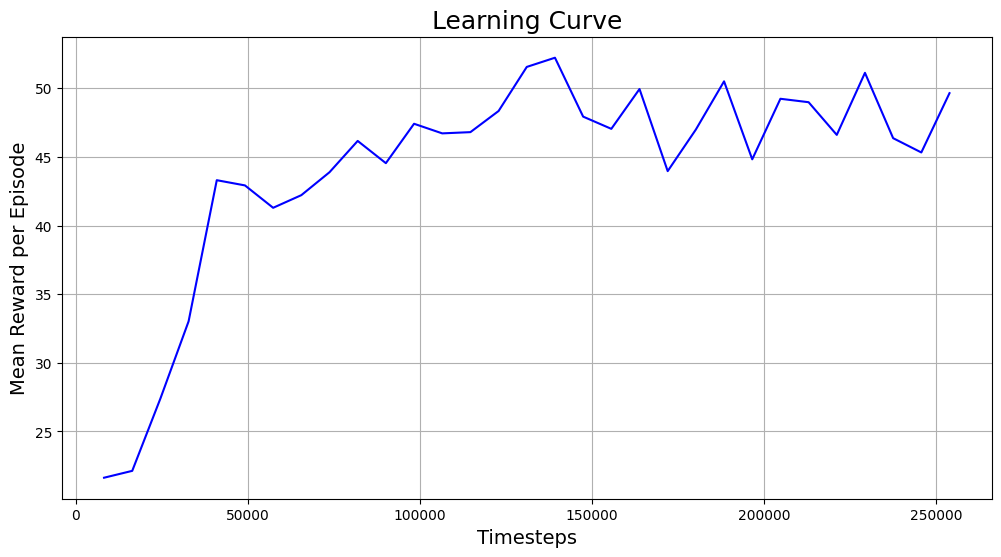


✅ Learning curve plotted and saved to /project/media/learning_curve.png


In [50]:
# ==============================================================================
# CELL 5: PLOT THE LEARNING CURVE
# ==============================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# --- Helper function to parse TensorBoard logs ---
def load_tensorboard_logs(log_dir):
    # Find the latest event file
    event_file = sorted([os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'tfevents' in f])[-1]

    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    # The tag for mean reward is 'rollout/ep_rew_mean'
    df = pd.DataFrame(ea.Scalars('rollout/ep_rew_mean'))
    return df['step'], df['value']

# --- Load the logs ---
LOG_DIR = "/project/logs/ppo_visual_cartpole_250k/PPO_1" # Path to the specific run
timesteps, rewards = load_tensorboard_logs(LOG_DIR)

# --- Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rewards, color='blue')
plt.title('Learning Curve', fontsize=18)
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Mean Reward per Episode', fontsize=14)
plt.grid(True)

# Save the plot
plt.savefig('/project/media/learning_curve.png')
plt.show()

print("\n✅ Learning curve plotted and saved to /project/media/learning_curve.png")